In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
import math

import plotly.express as px
import sqlite3

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score as shs

# import warnings
# warnings.filterwarnings('ignore')

In [157]:
def make_circle(r, n, noise = 30, seed = 1234):
    np.random.seed(seed)
    return [(math.cos(2*math.pi/n*x)*r+np.random.normal(-noise,noise), math.sin(2*math.pi/n*x)*r+np.random.normal(-noise,noise)) for x in range(1,n+1)]

small_circle = make_circle(100, 300, 10)
medium_circle = make_circle(300, 700, 20)
big_circle = make_circle(500, 1000, 30)

noise = [(np.random.randint(-600,600),np.random.randint(-600,600)) for i in range(300)]

<Axes: xlabel='x', ylabel='y'>

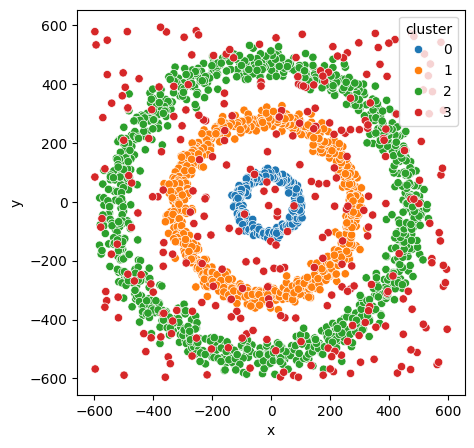

In [158]:
def arrray_to_df(arr, i):
    df = pd.DataFrame(arr)
    df['cluster'] = str(i)
    return df

data = [arrray_to_df(arr, i) for i, arr in enumerate([small_circle, medium_circle, big_circle, noise])]

data = pd.concat(data)
data.columns = ['x', 'y', 'cluster']


plt.rcParams['figure.figsize'] = [5,5]
sns.scatterplot(
data = data, 
x = 'x',
y = 'y',
hue = 'cluster'
)

<Axes: xlabel='x', ylabel='y'>

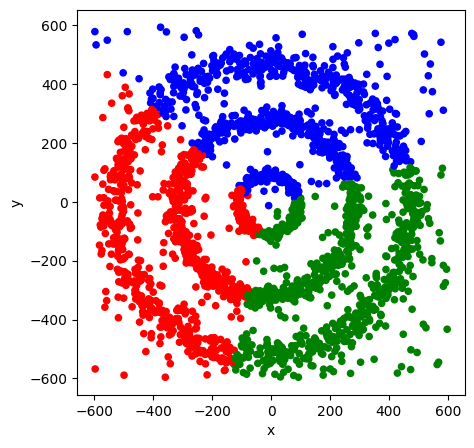

In [159]:
preds = KMeans(n_clusters = 3, random_state =123).fit_predict(data)

cols = { 
0: 'r',
1: 'g',
2: 'b'
}

data['kmeans_pred'] = [cols.get(pred) for pred in preds]
data.plot.scatter('x', 'y', c='kmeans_pred')

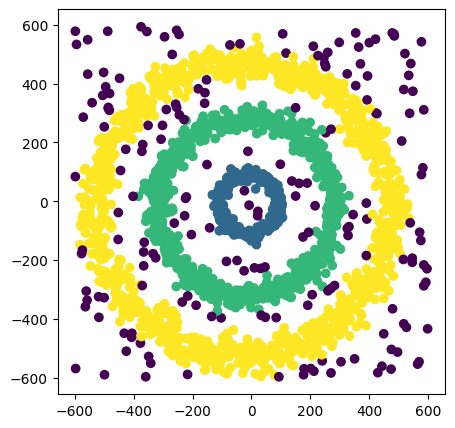

In [160]:
data['dbscan'] = DBSCAN(eps=32, min_samples=5).fit_predict(data[['x', 'y']])

plt.scatter(
    data['x'],
    data['y'],
    c = data['dbscan']
)

In [161]:
DB = sqlite3.connect('aruodas3.db')
C = DB.cursor()
sql="""SELECT * FROM aruododuomenys;"""
df = pd.read_sql_query(sql, con=DB)

In [162]:
df=df[df['miestas'] == 'Vilnius']
df=df.drop(columns='energetineklase')
df=df.dropna()

In [163]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(df[['ilguma','platuma']])
X_train_scaled = scaler.transform(df[['ilguma','platuma']])

In [164]:
ilguma_sc, platuma_sc = zip(*X_train_scaled)
df['ilguma_sc'] = ilguma_sc
df['platuma_sc'] = platuma_sc

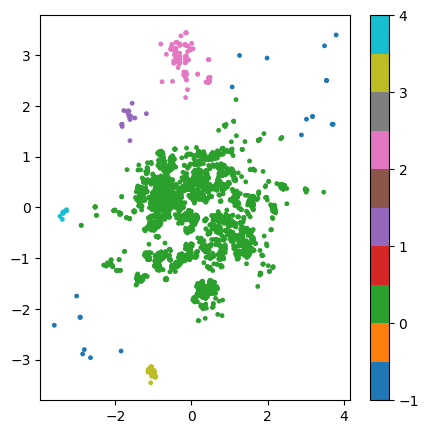

In [182]:
df['dbscan'] = DBSCAN(eps=0.5, min_samples=8).fit_predict(df[['ilguma_sc', 'platuma_sc']])

plt.scatter(
    df['ilguma_sc'],
    df['platuma_sc'],
    c = df['dbscan'],
    s = 6,
    cmap='tab10'
)
plt.colorbar()
plt.show()

In [177]:
from sklearn.metrics import silhouette_score as shs
shs(df[['ilguma_sc', 'platuma_sc']],df['dbscan']) # surandame Average Silhouette Score

np.float64(0.3180671220824234)

In [167]:
epsilon = np.linspace(0.001, 1, num = 20) # ε vertės
min_samples = np.arange(2,25,step=2) # MinPts vertės

In [168]:
# dabar implementuojam gridsearchcv:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'eps':epsilon,
    'min_samples':min_samples
}
dbscn = DBSCAN()
grid_search = GridSearchCV(dbscn, param_grid, scoring='accuracy')
grid_search.fit(df[['ilguma', 'platuma']])

best_eps = grid_search.best_params_['eps']
best_min_samples = grid_search.best_params_['min_samples']

print(best_eps, best_min_samples, sep='\n')

0.001
2


In [169]:
def GridSearch(combinations, X):
    '''
    Čia combinations - visos galimos epsilon ir minPts kombinacijos, kurias norime tikrinti
    X - data, kurią fitiname
    '''
    scores = [] # čia dėsime shs score
    all_labels = [] # čia dėsime predited labels
    for i, (eps, num_samples) in enumerate(combinations):
        predictions = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = predictions.labels_
        # ir klasterių pavadinimus: (jie gali kartotis, tad pasidarome set'ą - unikalių verčių sąrašą)
        clusters = list(set(labels))
        # randam klasterių kiekį:
        clusters_count = len(clusters)
        if -1 in clusters: # -1 žymimas noise, vadinasi, klasterių yra vienu mažiau, nei unikalių laibelių
            clusters_count = clusters_count - 1                      
        if (clusters_count < 2) and (clusters_count > 25): # jei rado mažiau nei 2 klasterius - blogai, turime dėmę
            # o viršutinė riba 25 - apsiribojame, kad nepridarytų belekiek klasterių, kas rodytų overfitinimą
            scores.append(-20)
            all_labels.append('Poor values')
            print(f'{i:4} iteracija skipinta', end='\r')
            continue
        if len(labels) > 2: # jei labelių bus 1 - silhouette fails, negalima toliau eiti
            try:
                scores.append(shs(X,labels))
                all_labels.append(labels)
                print(f'{i:4} iteracija pridėta', end="\r")
            except Exception as ex:
                print(f'{i:4} iteracija skipinta, klaida {ex}', end='\r')
    best_index = np.argmax(scores)
    best_params = combinations[best_index]
    best_labels = all_labels[best_index]
    best_score = scores[best_index]
    return {'eps':best_params[0], 'minPts':best_params[1],'labels':best_labels, 'score':best_score}


import itertools

combinations = list(itertools.product(epsilon,min_samples))

bp = GridSearch(combinations,df[['ilguma', 'platuma']])

In [170]:
for k,v in bp.items():
    print(k,v, sep = '\t')

eps	0.05357894736842105
minPts	2
labels	[0 0 0 ... 0 0 0]
score	0.5279157970992239


In [183]:
fig = px.scatter_mapbox(
    df,
    lat="ilguma",
    lon="platuma", color="dbscan",
    zoom=6,
    size_max=50, 
    title="Būsto kainos Vilniuje",
)

fig.update_layout(
    mapbox_style="open-street-map",  
    height=600
)

fig.show()